In [1]:
"""
Complete run_ssps workflow example.

This script demonstrates the full workflow equivalent to run_ssps from
dscim-testing/run_integration_result.py, including:
1. Generate synthetic climate data
2. Reduce damages for sectors
3. Generate damage functions
4. Calculate SCC with multiple discounting methods

This is a complete end-to-end example showing all new functionality.
"""



'\nComplete run_ssps workflow example.\n\nThis script demonstrates the full workflow equivalent to run_ssps from\ndscim-testing/run_integration_result.py, including:\n1. Generate synthetic climate data\n2. Reduce damages for sectors\n3. Generate damage functions\n4. Calculate SCC with multiple discounting methods\n\nThis is a complete end-to-end example showing all new functionality.\n'

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path

# Add parent directory to path
try:
    project_root = Path(__file__).resolve().parent.parent.parent
except NameError: # (this is for notebooks)
    project_root = Path().resolve().parent.parent  

sys.path.insert(0, str(project_root))

from dscim_new.config.schemas import (
    DSCIMConfig,
    ClimateDataConfig,
    DamageFunctionConfig,
    DiscountingConfig,
    SCCConfig,
)
from dscim_new.utils import ClimateDataGenerator, DamagesDataGenerator

from dscim_new.pipeline import (
    ReduceDamagesStep,
    GenerateDamageFunctionStep,
    CalculateSCCStep,
)

RICH_AVAILABLE = False

## Step 1: Generate Synthetic Climate Data

For this tutorial, we'll generate synthetic climate data. In production, you would load real climate model outputs.

In [4]:
# =========================================================================
# STEP 1: Generate Synthetic Climate Data
# =========================================================================
print("STEP 1: Generate Synthetic Climate Data")

climate_dir = Path("../workflow_output/climate_data")
climate_dir.mkdir(parents=True, exist_ok=True)

generator = ClimateDataGenerator(seed=42, verbose=True)
climate_paths = generator.generate_all_climate_data(str(climate_dir))

print("\n Climate data generated successfully!")
for key, path in climate_paths.items():
    print(f"  - {key}: {path}")

STEP 1: Generate Synthetic Climate Data

=== Generating GMST ===
Generating GMST data...
Generated GMST: 606 rows
Saved: ../workflow_output/climate_data/GMTanom_all_temp.csv

=== Generating GMSL ===
Generating GMSL data...
Generated GMSL: (101, 3)


/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=4, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: ../workflow_output/climate_data/coastal_gmsl.zarr

=== Generating FAIR Temperature ===
Generating FAIR temperature data...
Generated FAIR temperature: control=(301, 2, 10), pulse=(301, 2, 10, 2, 1)
Saved: ../workflow_output/climate_data/ar6_fair162_sim.nc

=== Generating FAIR GMSL ===
Generating FAIR GMSL data...
Generated FAIR GMSL: control=(301, 3, 10), pulse=(301, 3, 10, 2, 1)
Saved: ../workflow_output/climate_data/scenario_gmsl.nc4

=== Generating Pulse Conversion ===
Generating pulse conversion factors...
Generated pulse conversion: 2 gases
Saved: ../workflow_output/climate_data/conversion.nc4

✓ All climate data generated in: ../workflow_output/climate_data

 Climate data generated successfully!
  - gmst: ../workflow_output/climate_data/GMTanom_all_temp.csv
  - gmsl: ../workflow_output/climate_data/coastal_gmsl.zarr
  - fair_temperature: ../workflow_output/climate_data/ar6_fair162_sim.nc
  - fair_gmsl: ../workflow_output/climate_data/scenario_gmsl.nc4
  - pulse_conversion:

## Inspect

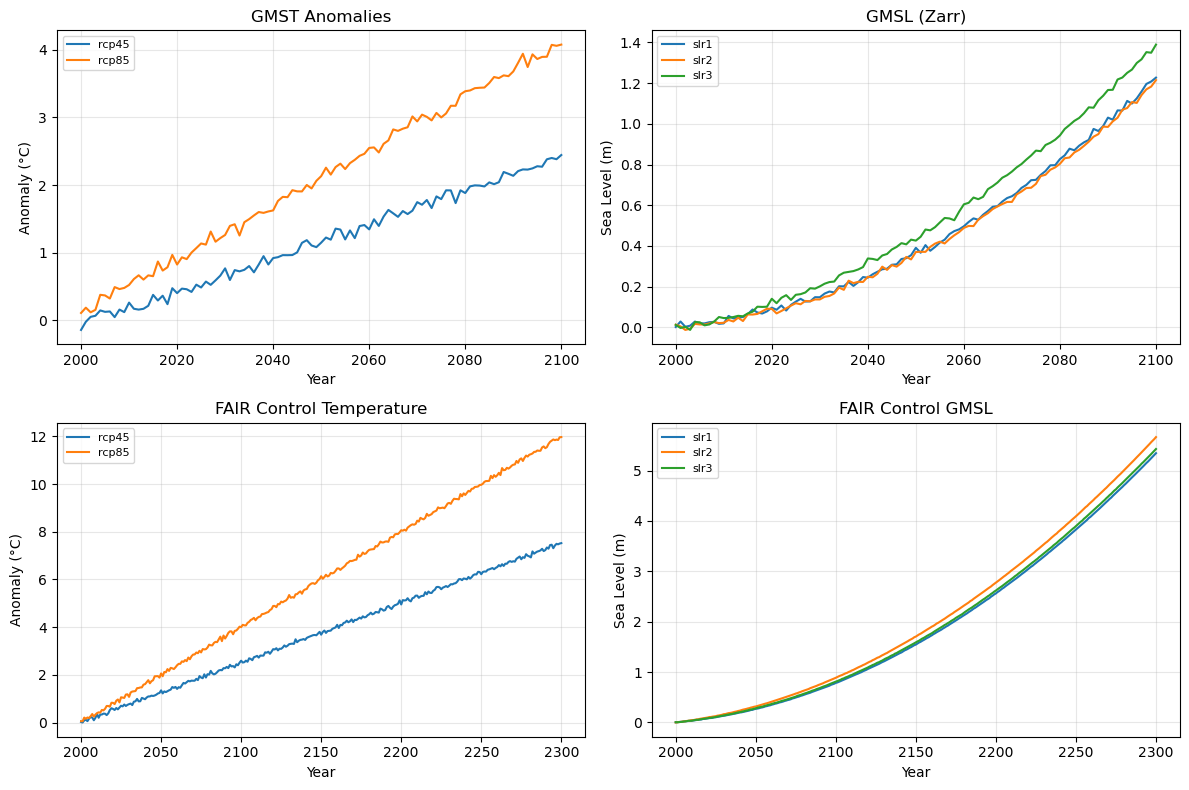

In [6]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

# === 1. GMST (CSV) ===
gmst = pd.read_csv(climate_paths["gmst"])
for rcp in gmst['rcp'].unique():
    subset = gmst[gmst['rcp'] == rcp].groupby('year')['anomaly'].mean()
    axes[0].plot(subset.index, subset.values, label=rcp, linewidth=1.5)
axes[0].set_title("GMST Anomalies")
axes[0].set_xlabel("Year"); axes[0].set_ylabel("Anomaly (°C)")
axes[0].legend(fontsize=8); axes[0].grid(True, alpha=0.3)

# === 2. GMSL (Zarr) ===
gmsl_ds = xr.open_zarr(climate_paths["gmsl"])
for slr in gmsl_ds['slr'].values:
    series = gmsl_ds['gmsl'].sel(slr=slr)
    axes[1].plot(gmsl_ds['year'], series, label=str(slr), linewidth=1.5)
axes[1].set_title("GMSL (Zarr)")
axes[1].set_xlabel("Year"); axes[1].set_ylabel("Sea Level (m)")
axes[1].legend(fontsize=8); axes[1].grid(True, alpha=0.3)

# === 3. FAIR Temperature (NetCDF) ===
fair_temp = xr.open_dataset(climate_paths["fair_temperature"])
for rcp in fair_temp['rcp'].values:
    da = fair_temp['control_temperature'].sel(rcp=rcp).mean('simulation')
    axes[2].plot(fair_temp['year'], da, label=rcp, linewidth=1.5)
axes[2].set_title("FAIR Control Temperature")
axes[2].set_xlabel("Year"); axes[2].set_ylabel("Anomaly (°C)")
axes[2].legend(fontsize=8); axes[2].grid(True, alpha=0.3)

# === 4. FAIR GMSL (NetCDF4) ===
fair_gmsl = xr.open_dataset(climate_paths["fair_gmsl"])
for slr in fair_gmsl['slr'].values:
    da = fair_gmsl['control_gmsl'].sel(slr=slr).mean('simulation')
    axes[3].plot(fair_gmsl['year'], da, label=str(slr), linewidth=1.5)
axes[3].set_title("FAIR Control GMSL")
axes[3].set_xlabel("Year"); axes[3].set_ylabel("Sea Level (m)")
axes[3].legend(fontsize=8); axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 2: Generate Synthetic Damages Data

In [7]:
# =========================================================================
# STEP 2: Generate Synthetic Damages Data
# =========================================================================
damages_dir = Path("../workflow_output/damages_data")
damages_dir.mkdir(parents=True, exist_ok=True)

damages_generator = DamagesDataGenerator(seed=42, verbose=True)
damages_paths = damages_generator.generate_all_damages_data(str(damages_dir))

print("\n Damages data generated successfully!")
for key, path in damages_paths.items():
    print(f"  - {key}: {path}")



=== Generating Economic Data ===
Generating economic data...
Generated economic data: (11, 5, 2, 2)
Saved: ../workflow_output/damages_data/econ/integration-econ.zarr

=== Generating Non-Coastal Sectoral Damages ===
Generating non-coastal damages (var names: delta_dummy, histclim_dummy)...
Generated non-coastal damages: (2, 2, 2, 11, 2, 5, 15)
Saved: ../workflow_output/damages_data/sectoral/noncoastal_damages.zarr

=== Generating Coastal Sectoral Damages ===
Generating coastal damages (var names: delta_coastal, histclim_coastal)...
Generated coastal damages: (2, 11, 15, 2, 2, 5)


/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=7, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=4, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this

Saved: ../workflow_output/damages_data/sectoral/coastal_damages.zarr

✓ All damages data generated in: ../workflow_output/damages_data

 Damages data generated successfully!
  - economic: ../workflow_output/damages_data/econ/integration-econ.zarr
  - noncoastal_damages: ../workflow_output/damages_data/sectoral/noncoastal_damages.zarr
  - coastal_damages: ../workflow_output/damages_data/sectoral/coastal_damages.zarr


Using SSP: ssp4, Model: iam1


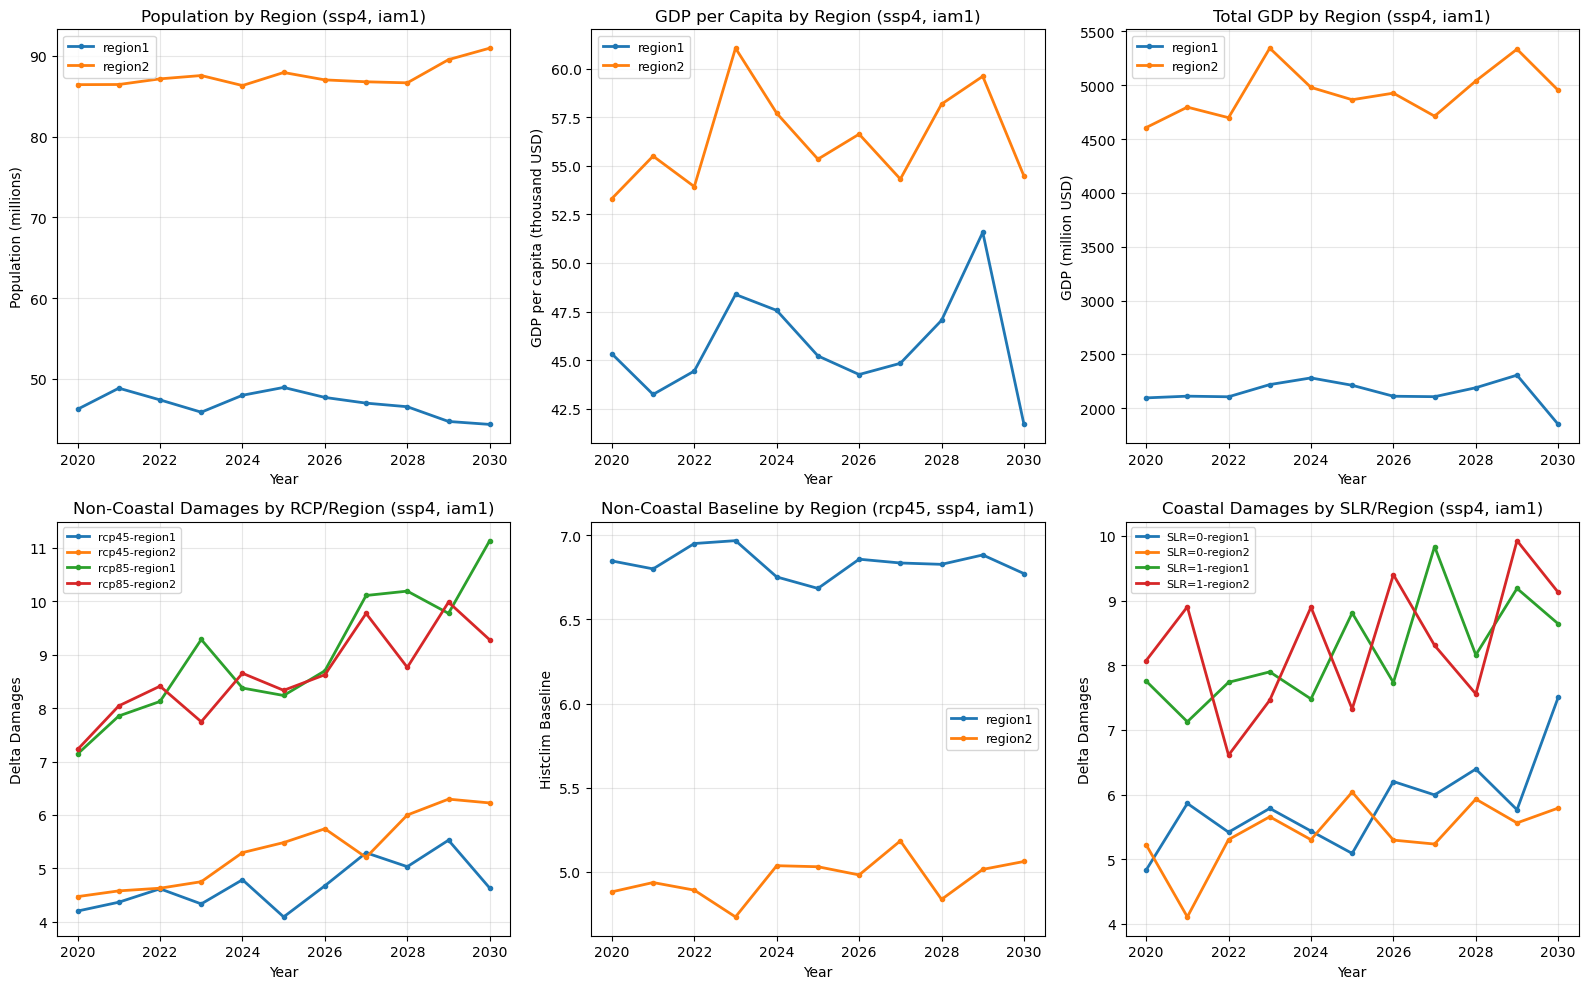

In [8]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Assuming damages_paths is returned from generate_all_damages_data() [fix this]
# If running separately, define the paths like this:
damages_paths = {
    "economic": "../workflow_output/damages_data/econ/integration-econ.zarr",
    "noncoastal_damages": "../workflow_output/damages_data/sectoral/noncoastal_damages.zarr",
    "coastal_damages": "../workflow_output/damages_data/sectoral/coastal_damages.zarr"
}

# Load datasets
econ_ds = xr.open_zarr(damages_paths["economic"])
noncoastal_ds = xr.open_zarr(damages_paths["noncoastal_damages"])
coastal_ds = xr.open_zarr(damages_paths["coastal_damages"])

# Select one random SSP and one random model
np.random.seed(42)
selected_ssp = np.random.choice(econ_ds['ssp'].values)
selected_model = np.random.choice(econ_ds['model'].values)

print(f"Using SSP: {selected_ssp}, Model: {selected_model}")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# === 1. Population by Region ===
for region in econ_ds['region'].values:
    pop = econ_ds['pop'].sel(ssp=selected_ssp, model=selected_model, region=region)
    axes[0].plot(econ_ds['year'], pop, label=region, linewidth=2, marker='o', markersize=3)
axes[0].set_title(f"Population by Region ({selected_ssp}, {selected_model})")
axes[0].set_xlabel("Year"); axes[0].set_ylabel("Population (millions)")
axes[0].legend(fontsize=9); axes[0].grid(True, alpha=0.3)

# === 2. GDP per Capita by Region ===
for region in econ_ds['region'].values:
    gdppc = econ_ds['gdppc'].sel(ssp=selected_ssp, model=selected_model, region=region)
    axes[1].plot(econ_ds['year'], gdppc, label=region, linewidth=2, marker='o', markersize=3)
axes[1].set_title(f"GDP per Capita by Region ({selected_ssp}, {selected_model})")
axes[1].set_xlabel("Year"); axes[1].set_ylabel("GDP per capita (thousand USD)")
axes[1].legend(fontsize=9); axes[1].grid(True, alpha=0.3)

# === 3. Total GDP by Region ===
for region in econ_ds['region'].values:
    gdp = econ_ds['gdp'].sel(ssp=selected_ssp, model=selected_model, region=region)
    axes[2].plot(econ_ds['year'], gdp, label=region, linewidth=2, marker='o', markersize=3)
axes[2].set_title(f"Total GDP by Region ({selected_ssp}, {selected_model})")
axes[2].set_xlabel("Year"); axes[2].set_ylabel("GDP (million USD)")
axes[2].legend(fontsize=9); axes[2].grid(True, alpha=0.3)

# === 4. Non-Coastal Damages (Delta) by RCP and Region ===
for rcp in noncoastal_ds['rcp'].values:
    for region in noncoastal_ds['region'].values:
        delta_mean = noncoastal_ds['delta_dummy'].sel(
            rcp=rcp, region=region, ssp=selected_ssp, model=selected_model
        ).mean(['gcm', 'batch'])
        axes[3].plot(noncoastal_ds['year'], delta_mean, label=f"{rcp}-{region}", linewidth=2, marker='o', markersize=3)
axes[3].set_title(f"Non-Coastal Damages by RCP/Region ({selected_ssp}, {selected_model})")
axes[3].set_xlabel("Year"); axes[3].set_ylabel("Delta Damages")
axes[3].legend(fontsize=8); axes[3].grid(True, alpha=0.3)

# === 5. Non-Coastal Historical Climate Baseline by Region ===
selected_rcp = noncoastal_ds['rcp'].values[0]  # Pick first RCP
for region in noncoastal_ds['region'].values:
    histclim_mean = noncoastal_ds['histclim_dummy'].sel(
        rcp=selected_rcp, region=region, ssp=selected_ssp, model=selected_model
    ).mean(['gcm', 'batch'])
    axes[4].plot(noncoastal_ds['year'], histclim_mean, label=region, linewidth=2, marker='o', markersize=3)
axes[4].set_title(f"Non-Coastal Baseline by Region ({selected_rcp}, {selected_ssp}, {selected_model})")
axes[4].set_xlabel("Year"); axes[4].set_ylabel("Histclim Baseline")
axes[4].legend(fontsize=9); axes[4].grid(True, alpha=0.3)

# === 6. Coastal Damages (Delta) by SLR and Region ===
for slr in coastal_ds['slr'].values:
    for region in coastal_ds['region'].values:
        delta_mean = coastal_ds['delta_coastal'].sel(
            slr=slr, region=region, ssp=selected_ssp, model=selected_model
        ).mean('batch')
        axes[5].plot(coastal_ds['year'], delta_mean, label=f"SLR={slr}-{region}", linewidth=2, marker='o', markersize=3)
axes[5].set_title(f"Coastal Damages by SLR/Region ({selected_ssp}, {selected_model})")
axes[5].set_xlabel("Year"); axes[5].set_ylabel("Delta Damages")
axes[5].legend(fontsize=8); axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## STEP 3: Setup Configuration


In [9]:
# =========================================================================
# STEP 3: Setup Configuration
# =========================================================================
print("STEP 3: Setup Configuration")

try:
    notebook_dir = Path(__file__).resolve().parent
except NameError:
    notebook_dir = Path().resolve()

config_path = notebook_dir.parent / "configs" / "full_config.yaml"
print(f"Loading configuration from: {config_path}")

base_config = DSCIMConfig.from_yaml(str(config_path))
print("Configuration loaded successfully")

STEP 3: Setup Configuration
Loading configuration from: /Users/sebastiancadavidsanchez/Documents/Github/cil/dscim-new/examples/configs/full_config.yaml
Configuration loaded successfully


In [10]:
# Add climate data configuration
base_config.climate_data = ClimateDataConfig(
    gmst_path=climate_paths["gmst"],
    gmsl_path=climate_paths["gmsl"],
    fair_temperature_path=climate_paths["fair_temperature"],
    fair_gmsl_path=climate_paths["fair_gmsl"],
    pulse_conversion_path=climate_paths["pulse_conversion"],
)

# Add damage function configuration
base_config.damage_function = DamageFunctionConfig(
    formula="damages ~ -1 + anomaly + np.power(anomaly, 2)",
    fit_type="ols",
    extrapolation_method="global_c_ratio",
    save_points=True,
    n_points=100,
)

# Add discounting configurations (multiple methods like original run_ssps)
base_config.discounting = [
    # Constant discounting at 2%
    DiscountingConfig(
        discount_type="constant",
        discount_rate=0.02,
    ),
    # Ramsey discounting
    DiscountingConfig(
        discount_type="ramsey",
        eta=1.45,
        rho=0.001,
    ),
    # GWR discounting
    DiscountingConfig(
        discount_type="gwr",
        eta=1.45,
        rho=0.001,
        gwr_method="naive_gwr",
    ),
]

# Add SCC configuration
base_config.scc = SCCConfig(
    pulse_years=[2020],
    fair_aggregation="mean",
    calculate_quantiles=True,
    quantile_levels=[0.05, 0.25, 0.5, 0.75, 0.95],
    save_discount_factors=True,
)

# Update output paths
base_config.paths.ssp_damage_function_library = "examples/workflow_output/damage_functions"
base_config.paths.AR6_ssp_results = "examples/workflow_output/scc_results"

print(" Configuration complete")
print(f"  - Sectors: {list(base_config.sectors.keys())}")
print(f"  - Pulse years: {base_config.scc.pulse_years}")
print(f"  - Discounting methods: {[d.discount_type for d in base_config.discounting]}")

 Configuration complete
  - Sectors: ['not_coastal', 'coastal']
  - Pulse years: [2020]
  - Discounting methods: ['constant', 'ramsey', 'gwr']


## STEP 4: Process Each Sector

In [11]:
# =========================================================================
# STEP 4: Process Each Sector
# =========================================================================
print("STEP 4: Process Each Sector")

# For this example, we'll process one sector
# In full workflow, you'd loop over all sectors
sectors_to_process = ["not_coastal"]  # Can extend to list(base_config.sectors.keys())
pulse_year = 2020
recipe = "adding_up"
reduction = "cc"

for sector in sectors_to_process:
    print(f"\nProcessing sector: {sector}")
    
    # Get sector configuration
    sector_config = base_config.sectors[sector]

    # ---------------------------------------------------------------------
    # Step 4a: Reduce Damages
    # ---------------------------------------------------------------------
    print(f"\n[4a] Reducing damages for {sector}...")

    reduce_step = ReduceDamagesStep(
        config=base_config,
        sector=sector,
        recipe=recipe,
        reduction=reduction,
        verbose=True,
    )

    # Prepare inputs with required paths
    reduce_inputs = {
        'sector_damages_path': sector_config.sector_path,
        'socioec_path': base_config.econdata.global_ssp
    }

    # Run reduce damages
    reduce_outputs = reduce_step.run(inputs=reduce_inputs, save=True)
    reduced_damages = reduce_outputs["reduced_damages"]

    print(f"Dimensions: {list(reduced_damages.dims)}")

    # ---------------------------------------------------------------------
    # Step 4b: Generate Damage Functions
    # ---------------------------------------------------------------------
    print(f"\n[4b] Generating damage function for {sector}...")

    df_step = GenerateDamageFunctionStep(
        config=base_config,
        sector=sector,
        pulse_year=pulse_year,
        verbose=True,
    )

    # Run damage function generation
    df_outputs = df_step.run(
        inputs={"reduced_damages": reduced_damages},
        save=True
    )

    coefficients = df_outputs["damage_function_coefficients"]
    marginal_damages = df_outputs["marginal_damages"]

    print(f"Damage function generated")
    print(f"Coefficients: {list(coefficients.coefficient.values)}")
    #print(f"Marginal damages shape: {marginal_damages.shape}")

    # ---------------------------------------------------------------------
    # Step 4c: Calculate SCC for Each Discounting Method
    # ---------------------------------------------------------------------
    print(f"\n[4c] Calculating SCC for {sector}...")

    # We'll need consumption data for Ramsey/GWR
    # For this example, we'll load from the economic data
    import xarray as xr
    econ_data = xr.open_zarr(base_config.econdata.global_ssp, chunks=None)

    # Get consumption (gdppc * pop) or use gdppc as proxy
    if 'gdppc' in econ_data.data_vars:
        consumption = econ_data['gdppc']
    else:
        raise ValueError("Economic data must contain 'gdppc' variable")

    scc_results = {}

    for discount_idx, discount_config in enumerate(base_config.discounting):
        discount_name = discount_config.discount_type
        print(f"\nCalculating SCC with {discount_name} discounting...")

        scc_step = CalculateSCCStep(
            config=base_config,
            sector=sector,
            pulse_year=pulse_year,
            discount_config_index=discount_idx,
            verbose=True,
        )

        # Run SCC calculation
        scc_outputs = scc_step.run(
            inputs={
                "marginal_damages": marginal_damages,
                "consumption": consumption,
            },
            save=True
        )

        scc = scc_outputs["scc"]


STEP 4: Process Each Sector

Processing sector: not_coastal

[4a] Reducing damages for not_coastal...


Processing not_coastal (adding_up | cc)

Output()

                                        Result Summary                                         
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Variable     ┃ Shape                     ┃            Mean ┃                          Range ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cc           │ (11, 5, 2, 2, 2, 2)       │           54.41 │                 [39.39, 91.76] │
└──────────────┴───────────────────────────┴─────────────────┴────────────────────────────────┘

Dimensions: ['model', 'region', 'ssp', 'year', 'gcm', 'rcp']

[4b] Generating damage function for not_coastal...


/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=4, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=5, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Generating damage function for not_coastal, pulse year 2020                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Loading GMSL data from ../workflow_output/climate_data/coastal_gmsl.zarr

Fitting damage function using OLS regression

R-squared: 0.9287

Number of observations: 2640

Calculating marginal damages

Generating 100 evaluation points for visualization

✓ Damage function generation complete

Damage function generated
Coefficients: [np.str_('anomaly'), np.str_('np.power(anomaly, 2)')]

[4c] Calculating SCC for not_coastal...

Calculating SCC with constant discounting...


/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=20, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calculating SCC for not_coastal, pulse year 2020                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Calculating constant discount factors

Using constant discount rate: 0.0200

Computing discounted marginal damages and summing over time

Aggregating SCC using method: mean

Calculating quantiles: [0.05, 0.25, 0.5, 0.75, 0.95]

SCC calculation complete

✓ SCC calculation complete

/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=4, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(



Calculating SCC with ramsey discounting...


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calculating SCC for not_coastal, pulse year 2020                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Calculating ramsey discount factors

Using Ramsey discounting: eta=1.45, rho=0.001

Computing discounted marginal damages and summing over time

Aggregating SCC using method: mean

Calculating quantiles: [0.05, 0.25, 0.5, 0.75, 0.95]

SCC calculation complete

✓ SCC calculation complete

/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=4, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=7, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this


Calculating SCC with gwr discounting...


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calculating SCC for not_coastal, pulse year 2020                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Calculating gwr discount factors

Using GWR discounting (naive_gwr): eta=1.45, rho=0.001

Computing discounted marginal damages and summing over time

Aggregating SCC using method: mean

Calculating quantiles: [0.05, 0.25, 0.5, 0.75, 0.95]

SCC calculation complete

✓ SCC calculation complete

/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=7, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/Users/sebastiancadavidsanchez/miniconda3/envs/dscim-refactoring/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=4, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this

In [12]:
scc_outputs

{'scc': <xarray.DataArray (slr: 3, region: 2)> Size: 48B
 dask.array<sum-aggregate, shape=(3, 2), dtype=float64, chunksize=(3, 2), chunktype=numpy.ndarray>
 Coordinates:
   * slr      (slr) <U4 48B 'slr1' 'slr2' 'slr3'
   * region   (region) <U7 56B 'region1' 'region2'
 Attributes:
     calculation:  uncollapsed_scc
     pulse_year:   2020
     units:        dollars_per_ton_CO2,
 'discount_factors': <xarray.DataArray 'gdppc' (year: 11, region: 2)> Size: 176B
 array([[1.        , 1.        ],
        [0.97171106, 0.98385085],
        [0.98434115, 0.97990058],
        [0.99789763, 0.97732113],
        [1.00016239, 0.97987819],
        [0.98824666, 0.93218977],
        [0.99239034, 0.98283513],
        [0.98705878, 0.99394038],
        [1.0213467 , 0.92350086],
        [0.97425642, 0.96002012],
        [0.92933729, 0.99798352]])
 Coordinates:
   * region   (region) <U7 56B 'region1' 'region2'
   * year     (year) int64 88B 2020 2021 2022 2023 2024 ... 2027 2028 2029 2030
 Attributes:
    

In [16]:
ls ../workflow_output/reduced_damages/not_coastal

adding_up_cc.zarr/
